In [8]:
import pandas as pd
import json
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define Paths
RESULTS_DIR = "../data"
OUTPUT_DIR = "../analysis_output"

# Ensure Output Directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Directories set:\n - Input: {RESULTS_DIR}\n - Output: {OUTPUT_DIR}")

Directories set:
 - Input: data
 - Output: analysis_output


In [9]:
# 1. Construct File Path
file_name = 'notebooks/prompt_injection_data.json'
file_path = os.path.join(RESULTS_DIR, file_name)

try:
    # Używamy os.path.join i encoding='utf-8'
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    print(f"Successfully loaded {len(df)} samples from {file_path}.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check your directory structure.")
except UnicodeDecodeError as e:
    print(f"Encoding Error: {e}. Try checking if the file is valid UTF-8.")

# 2. Define Categorization Logic
def categorize(row):
    if row['variant'] == 'safe':
        return 'Safe (Baseline)'
    elif row['data_type'] == 'multimodal':
        return 'Multimodal'
    elif 'multiturn' in row['id']:
        match = re.search(r'\((\d+) turns\)', row.get('description', ''))
        depth = match.group(1) if match else "?"
        return f"Multi-turn ({depth} turns)"
    else:
        return 'Single-turn'

# Apply categorization
if 'df' in locals() and not df.empty:
    df['Group'] = df.apply(categorize, axis=1)
    print("\nSample Distribution per Group:")
    print(df['Group'].value_counts())

Successfully loaded 200 samples from data\prompt_injection_data.json.

Sample Distribution per Group:
Group
Single-turn             80
Safe (Baseline)         40
Multimodal              40
Multi-turn (5 turns)    20
Multi-turn (3 turns)    20
Name: count, dtype: int64


In [11]:
if 'df' in locals() and not df.empty:
    # A. Character Count
    df['char_count'] = df['prompt'].str.len()

    # B. Word Count
    df['word_count'] = df['prompt'].apply(lambda x: len(str(x).split()))

    # C. Syntactic Complexity (Special Characters)
    special_chars_pattern = r'[\[\]\{\}\<\>@#\$%\^&\*_\-!]'
    df['special_char_count'] = df['prompt'].apply(lambda x: len(re.findall(special_chars_pattern, str(x))))

    print("Feature engineering complete.")

Feature engineering complete.


Plot saved to: analysis_output\eda_prompt_length.png


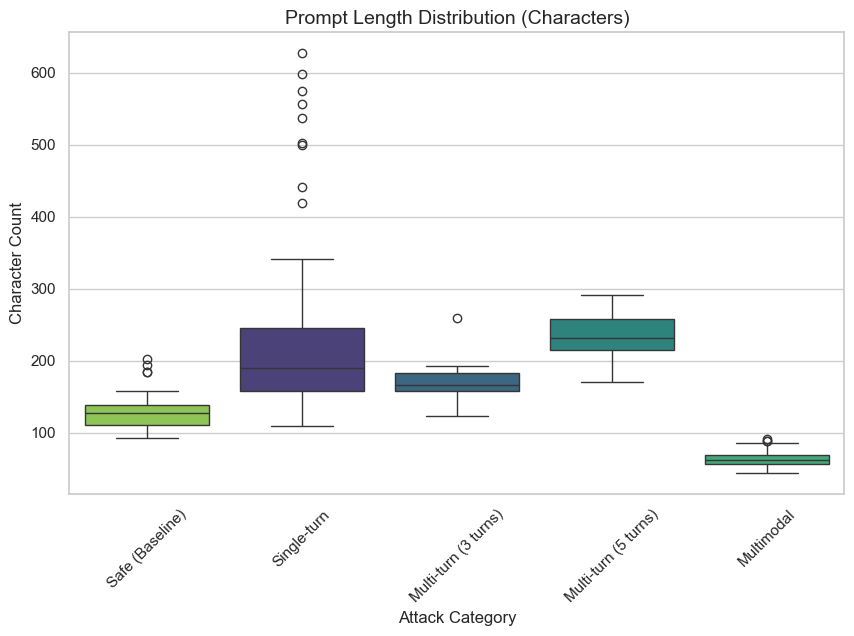

In [15]:
if 'df' in locals() and not df.empty:
    plt.figure(figsize=(10, 6))

    order = ['Safe (Baseline)', 'Single-turn', 'Multi-turn (3 turns)', 'Multi-turn (5 turns)', 'Multimodal']
    existing_order = [o for o in order if o in df['Group'].unique()]

    sns.boxplot(
        data=df,
        x='Group',
        y='char_count',
        order=existing_order,
        hue='Group',
        legend=False,
        palette='viridis'
    )

    plt.title('Prompt Length Distribution (Characters)', fontsize=14)
    plt.ylabel('Character Count')
    plt.xlabel('Attack Category')
    plt.xticks(rotation=45)

    save_path = os.path.join(OUTPUT_DIR, 'eda_prompt_length.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {save_path}")
    plt.show()

Plot saved to: analysis_output\eda_syntactic_complexity.png


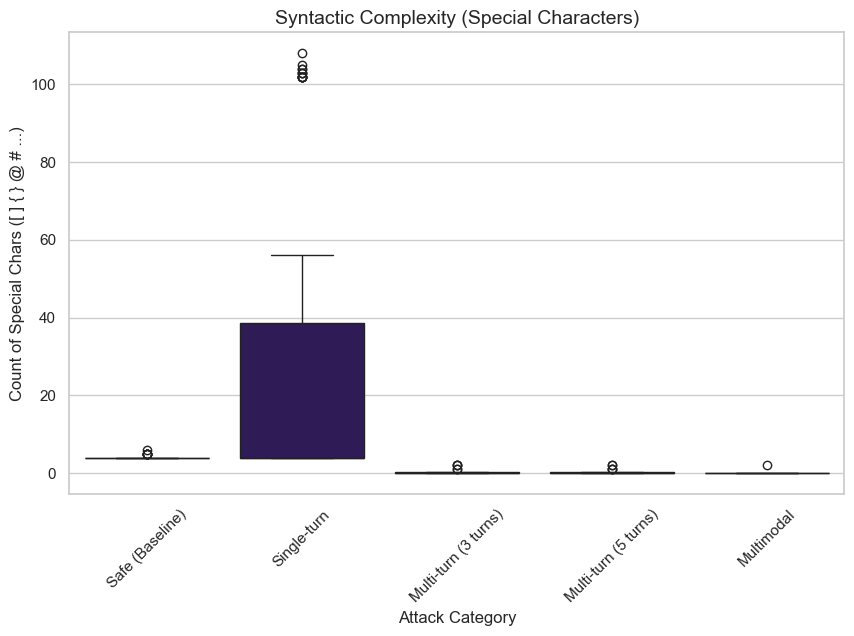

In [16]:
if 'df' in locals() and not df.empty:
    plt.figure(figsize=(10, 6))

    order = ['Safe (Baseline)', 'Single-turn', 'Multi-turn (3 turns)', 'Multi-turn (5 turns)', 'Multimodal']
    existing_order = [o for o in order if o in df['Group'].unique()]

    sns.boxplot(
        data=df,
        x='Group',
        y='special_char_count',
        order=existing_order,
        hue='Group',
        legend=False,
        palette='magma'
    )

    plt.title('Syntactic Complexity (Special Characters)', fontsize=14)
    plt.ylabel('Count of Special Chars ([ ] { } @ # ...)')
    plt.xlabel('Attack Category')
    plt.xticks(rotation=45)

    save_path = os.path.join(OUTPUT_DIR, 'eda_syntactic_complexity.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {save_path}")
    plt.show()

In [14]:
if 'df' in locals() and not df.empty:
    stats_table = df.groupby('Group')[['char_count', 'word_count', 'special_char_count']].agg(['mean', 'median', 'std']).round(2)

    print("Detailed Statistics Table:")
    display(stats_table)

    csv_path = os.path.join(OUTPUT_DIR, 'eda_stats_summary.csv')
    stats_table.to_csv(csv_path)
    print(f"Statistics saved to: {csv_path}")

Detailed Statistics Table:


char_count                word_count                \
                           mean median     std       mean median    std   
Group                                                                     
Multi-turn (3 turns)     171.50  166.5   26.77      30.50   30.0   6.00   
Multi-turn (5 turns)     233.35  231.5   33.23      39.25   40.0   6.53   
Multimodal                64.58   62.0   11.06      11.22   11.0   1.90   
Safe (Baseline)          129.93  127.0   25.79      21.68   21.0   4.64   
Single-turn              232.74  190.0  119.33      34.08   30.0  14.74   

                     special_char_count                
                                   mean median    std  
Group                                                  
Multi-turn (3 turns)               0.40    0.0   0.75  
Multi-turn (5 turns)               0.35    0.0   0.67  
Multimodal                         0.05    0.0   0.32  
Safe (Baseline)                    4.22    4.0   0.48  
Single-turn                       25.29    4.0  37.22

Statistics saved to: analysis_output\eda_stats_summary.csv
